In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import joblib


In [ ]:
csv_path = "/content/drive/MyDrive/pakistan_tomato_disease_forecast4000.csv"

df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (14610, 19)


,date,tmax,tmin,rain,rhmax,rhmin,solar,wind,city,tmean,rhmean,LeafWetness_est,LateBlight_Risk,EarlyBlight_Risk,BacterialSpot_Risk,MosaicVirus_Risk,YellowVirus_Risk,LeafMold_Risk,Septoria_Risk
0,2021-01-01,16.2,5.0,0.0,96,52,12.08,9.5,Lahore,10.60,74.0,0,Low,Low,Low,Low,Low,Low,Low
1,2021-01-02,16.1,3.7,2.6,100,59,9.51,11.7,Lahore,9.90,79.5,1,Low,Low,Low,Low,Low,Low,Low
2,2021-01-03,18.0,10.2,2.4,95,69,7.90,15.3,Lahore,14.10,82.0,1,Low,Low,Low,Low,Low,Low,Low
3,2021-01-04,19.6,12.4,11.2,97,68,7.87,15.5,Lahore,16.00,82.5,1,Medium,Low,Low,Low,Low,Low,Low
4,2021-01-05,16.3,13.8,23.1,95,90,3.34,20.5,Lahore,15.05,92.5,1,High,Low,Low,Low,Low,Low,Low


In [ ]:
# Convert date and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Target columns
target_cols = [
    'LateBlight_Risk','EarlyBlight_Risk','BacterialSpot_Risk',
    'MosaicVirus_Risk','YellowVirus_Risk','LeafMold_Risk','Septoria_Risk'
]

# Encode city
city_encoder = LabelEncoder()
df['city'] = city_encoder.fit_transform(df['city'])

# Encode targets (Low/Medium/High)
encoders = {}
y_encoded = pd.DataFrame()

for col in target_cols:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(columns=target_cols + ['date'])
y = y_encoded


In [ ]:
split_index = int(0.8 * len(df))

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (11688, 11)
Test shape: (2922, 11)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "/content/drive/MyDrive/rf_scaler.pkl")
print("Scaler saved.")


Scaler saved.


In [ ]:
rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

multi_rf = MultiOutputClassifier(rf_base)
multi_rf.fit(X_train_scaled, y_train)

print("🎉 Training Complete!")


🎉 Training Complete!


In [ ]:
# Make predictions (matrix shape: samples x 7 diseases)
y_pred = multi_rf.predict(X_test_scaled)


In [ ]:
from sklearn.metrics import classification_report

for i, col in enumerate(target_cols):
    print(f"\n📌 {col} Report:")

    y_true_col = y_test[col]
    y_pred_col = y_pred[:, i]

    labels = sorted(list(y_true_col.unique()))

    if len(labels) == 3:
        target_names = ["Low", "Medium", "High"]
    elif len(labels) == 2:
        target_names = ["Low", "High"]
    else:
        target_names = [str(l) for l in labels]

    print(classification_report(
        y_true_col,
        y_pred_col,
        labels=labels,
        target_names=target_names,
        digits=4,
        zero_division=0
    ))



📌 LateBlight_Risk Report:
              precision    recall  f1-score   support

         Low     1.0000    1.0000    1.0000      2860
        High     1.0000    1.0000    1.0000        62

    accuracy                         1.0000      2922
   macro avg     1.0000    1.0000    1.0000      2922
weighted avg     1.0000    1.0000    1.0000      2922


📌 EarlyBlight_Risk Report:
              precision    recall  f1-score   support

         Low     1.0000    1.0000    1.0000       128
      Medium     1.0000    1.0000    1.0000      2739
        High     1.0000    1.0000    1.0000        55

    accuracy                         1.0000      2922
   macro avg     1.0000    1.0000    1.0000      2922
weighted avg     1.0000    1.0000    1.0000      2922


📌 BacterialSpot_Risk Report:
              precision    recall  f1-score   support

         Low     1.0000    1.0000    1.0000       123
      Medium     1.0000    1.0000    1.0000      2739
        High     1.0000    1.0000    1.0000 

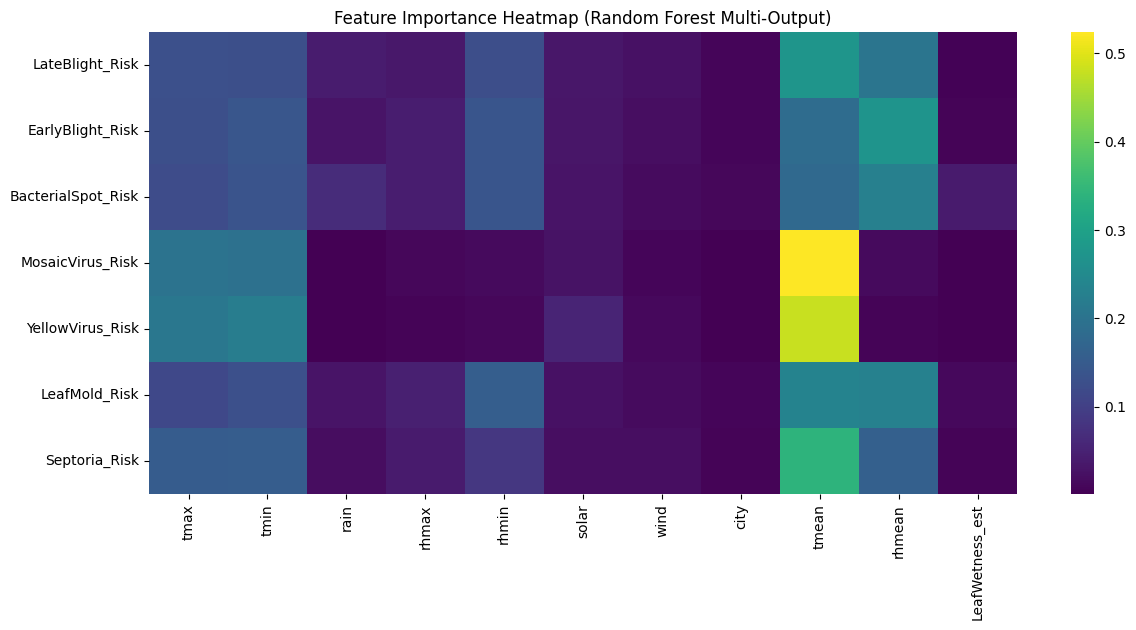

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feature_names = X_train.columns
importance_matrix = []

for i, col in enumerate(target_cols):
    rf_single = multi_rf.estimators_[i]  # RF for disease i
    importance_matrix.append(rf_single.feature_importances_)

importance_matrix = np.array(importance_matrix)

plt.figure(figsize=(14, 6))
sns.heatmap(importance_matrix,
            xticklabels=feature_names,
            yticklabels=target_cols,
            cmap="viridis")
plt.title("Feature Importance Heatmap (Random Forest Multi-Output)")
plt.show()


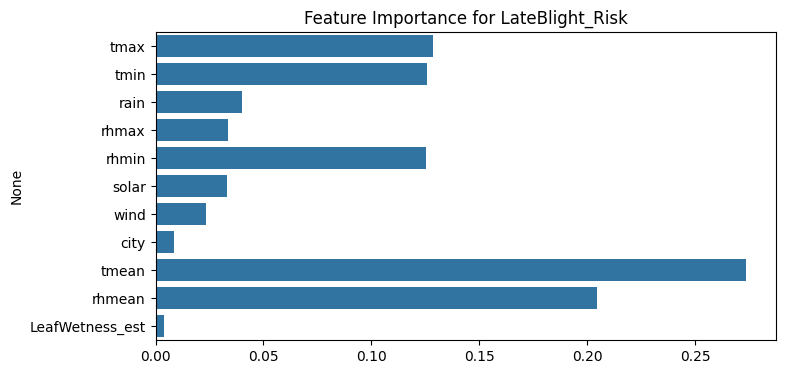

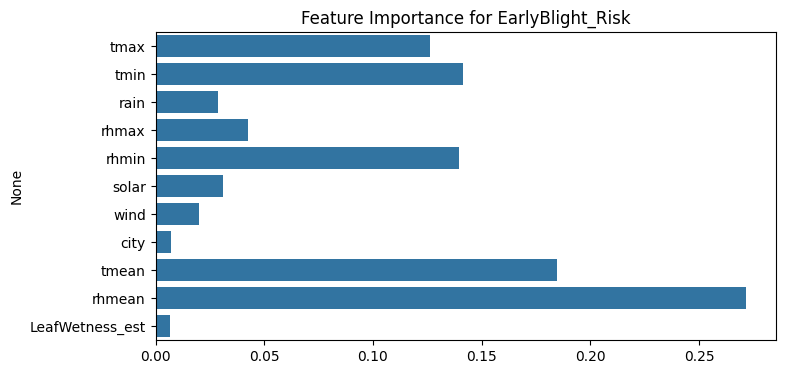

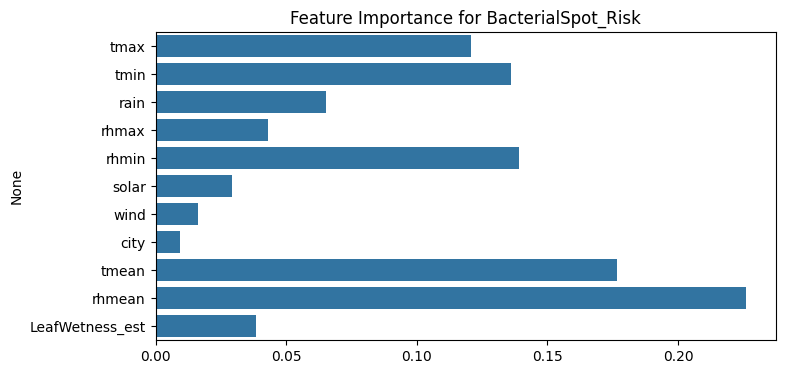

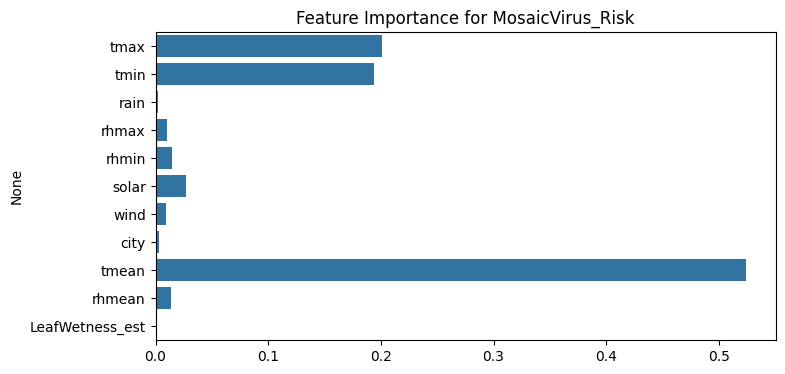

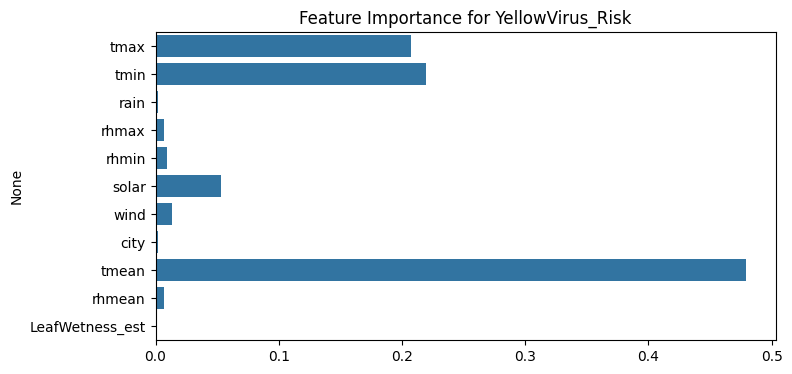

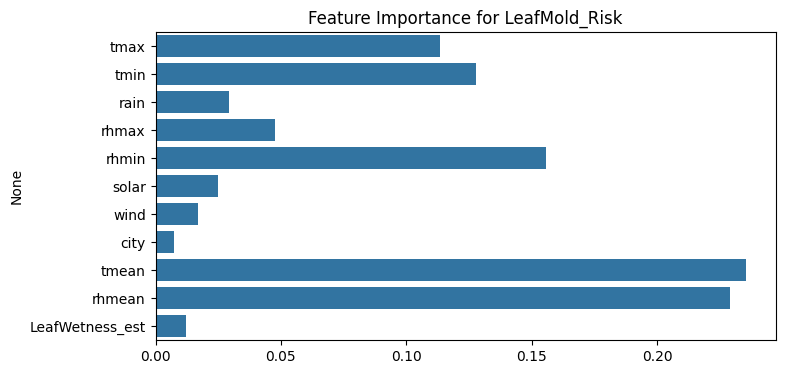

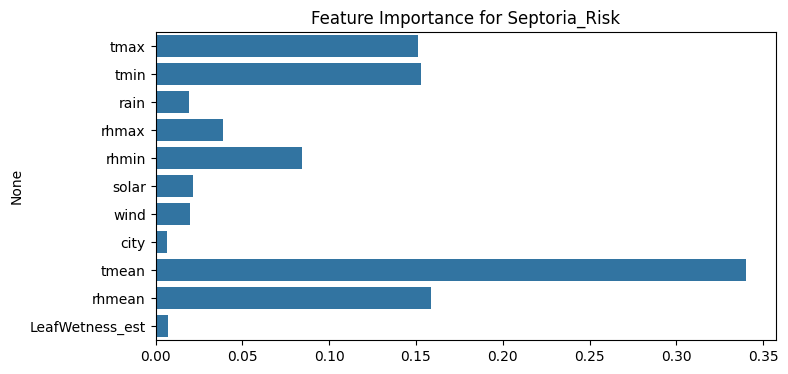

In [ ]:
for i, col in enumerate(target_cols):
    rf_single = multi_rf.estimators_[i]
    importances = rf_single.feature_importances_

    plt.figure(figsize=(8, 4))
    sns.barplot(x=importances, y=feature_names)
    plt.title(f"Feature Importance for {col}")
    plt.show()


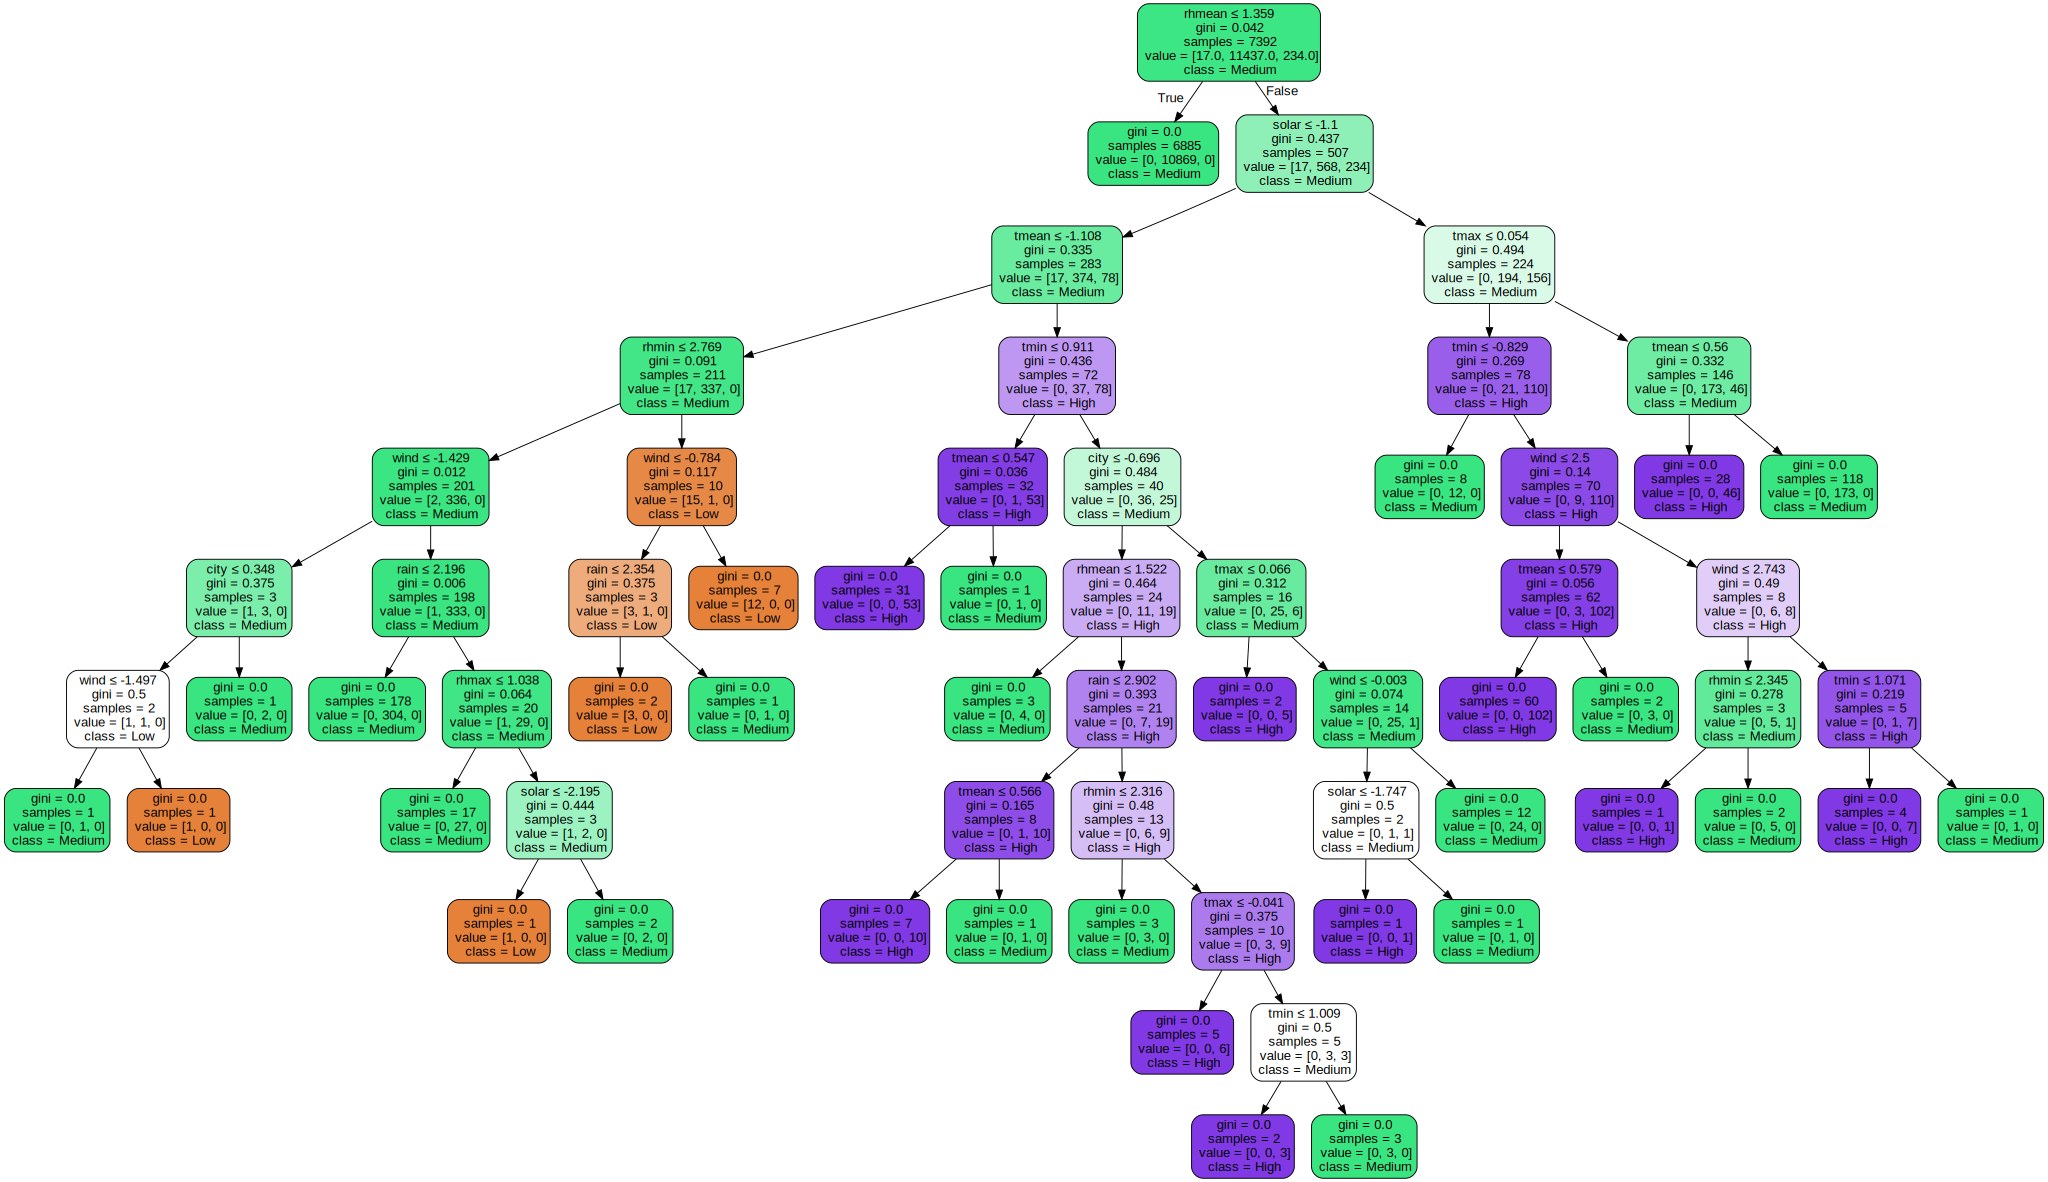

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

d_index = 0   # 0 = LateBlight_Risk
t_index = 0   # tree number in RF

tree = multi_rf.estimators_[d_index].estimators_[t_index]

dot = export_graphviz(
    tree,
    out_file=None,
    feature_names=feature_names,
    class_names=["Low", "Medium", "High"],
    filled=True,
    rounded=True,
    special_characters=True
)

graphviz.Source(dot)


In [ ]:
import joblib

save_path = "/content/drive/MyDrive/tomato_rf_model.pkl"
joblib.dump(multi_rf, save_path)

print("Random Forest Model Saved At:", save_path)


Random Forest Model Saved At: /content/drive/MyDrive/tomato_rf_model.pkl


In [ ]:
import h5py
import joblib
import pickle

save_path = "/content/drive/MyDrive/tomato_rf_model.h5"

# Serialize model using pickle
model_bytes = pickle.dumps(multi_rf)

with h5py.File(save_path, 'w') as f:
    f.create_dataset("random_forest_model", data=np.void(model_bytes))

print("Random Forest saved as H5 at:", save_path)


Random Forest saved as H5 at: /content/drive/MyDrive/tomato_rf_model.h5


In [ ]:
import h5py
import pickle

load_path = "/content/drive/MyDrive/tomato_rf_model.h5"

with h5py.File(load_path, 'r') as f:
    model_bytes = bytes(f["random_forest_model"][()])
    loaded_rf = pickle.loads(model_bytes)

print("Model Loaded Successfully!")


Model Loaded Successfully!
